In [16]:
import numpy as np 
import pandas as pd 

df = pd.read_csv("IT_2013p_EUSILC.csv")

df.head()

,PB010,PB020,PB030,PB040,PB060,PB100,PB110,PB120,PB130,PB140,...,PW190,PW200,PW210,PW220,PX010,PX020,PX030,PX040,PX050,PX200
0,2013,IT,821,1431.730769,NaN,2,2013,10.0,1,1932,...,8.0,8.0,8.0,NaN,1,80,82,1,6.0,543.652549
1,2013,IT,1031,1431.730769,NaN,3,2013,14.0,4,1964,...,6.0,9.0,8.0,NaN,1,48,103,1,2.0,1753.075882
2,2013,IT,1371,1431.730769,NaN,4,2013,16.0,2,1979,...,6.0,8.0,8.0,NaN,1,33,137,1,6.0,NaN
3,2013,IT,1631,1431.730769,NaN,4,2013,1.0,2,1953,...,6.0,NaN,NaN,2.0,1,59,163,1,2.0,8765.280972
4,2013,IT,1831,1431.730769,NaN,2,2013,9.0,3,1932,...,NaN,8.0,NaN,3.0,1,80,183,1,6.0,7884.221284


In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm

In [7]:
import pingouin as pg

(array([ 595.,    0.,    0.,  228.,    0.,    0.,  359.,    0.,    0.,
         559.,    0.,    0., 1067.,    0.,    0., 3072.,    0.,    0.,
        4641.,    0.,    0., 5429.,    0.,    0., 5233.,    0.,    0.,
        1706.,    0., 1622.]),
 array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
         1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
         3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
         5.        ,  5.33333333,  5.66666667,  6.        ,  6.33333333,
         6.66666667,  7.        ,  7.33333333,  7.66666667,  8.        ,
         8.33333333,  8.66666667,  9.        ,  9.33333333,  9.66666667,
        10.        ]),
 <BarContainer object of 30 artists>)

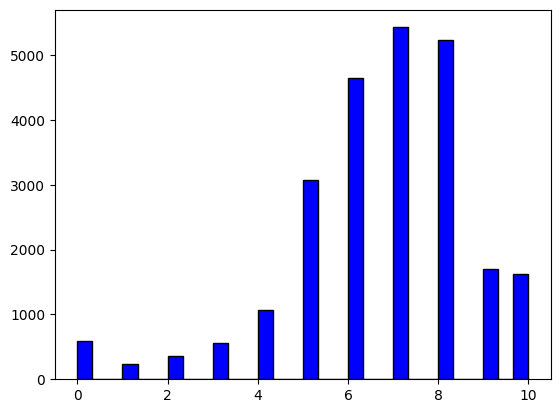

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

df["PW010"] = df["PW010"].replace(99, np.nan)
plt.hist(df['PW010'], bins=30, color='blue', edgecolor='black')

In [18]:
# czyszczenie danych
Y = "PW010"      # dobrostan (0-10)
W = "PX200"      # waga wellbeing

WORK = "PL031"   # status pracy (kategoria)
HEALTH = "PH010" # samoocena zdrowia (kategoria)
SEC = "PW220"    # poczucie bezpieczeństwa (często skala; jeśli masz braki, będzie NaN)

AGE = "PX020"    # wiek
SEX = "PB150"    # płeć (kategoria)
EDU = "PE040"    # edukacja (kategoria)
INCOME = "PY010G"  # dochód (ciągła) -> zrobimy log(1+)

def clean_silc_numeric(s):
    """Konwertuje do numeric, a wartości <0 traktuje jako braki."""
    s = pd.to_numeric(s, errors="coerce")
    return s.where(s >= 0, np.nan)

# Czyścimy tylko to, czego używamy
use_cols = [Y, W, WORK, HEALTH, SEC, AGE, SEX, EDU, INCOME]
use_cols = [c for c in use_cols if c in df.columns]
for c in use_cols:
    df[c] = clean_silc_numeric(df[c])

# Transformacje
df["age"] = df[AGE]
df["age2"] = df["age"]**2
df["ln_income"] = np.log1p(df[INCOME]) if INCOME in df.columns else np.nan

In [19]:
# Zostawiamy obserwacje z Y i wagą
d = df[[Y, W, WORK, HEALTH, SEC, "age", "age2", SEX, EDU, "ln_income"]].dropna(subset=[Y, W]).copy()

# Kategorie
for c in [WORK, HEALTH, SEX, EDU]:
    if c in d.columns:
        d[c] = d[c].astype("category")

In [20]:
# średnia ważona + 95% CI (aproksymacja przez efektywną liczebność Kish'a)

def weighted_mean_ci(x, w, alpha=0.05):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)

    mask = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[mask], w[mask]
    if len(x) < 3:
        return np.nan, np.nan, np.nan

    mean = np.sum(w * x) / np.sum(w)

    # ważona wariancja (populacyjna)
    var_w = np.sum(w * (x - mean) ** 2) / np.sum(w)

    # efektywna liczebność (Kish)
    n_eff = (np.sum(w) ** 2) / np.sum(w ** 2)

    se = np.sqrt(var_w / n_eff)
    z = stats.norm.ppf(1 - alpha / 2)
    return mean, mean - z * se, mean + z * se

def weighted_group_stats(df, group_col, y_col=Y, w_col=W):
    out = []
    for g, sub in df.groupby(group_col, observed=True):
        m, lo, hi = weighted_mean_ci(sub[y_col], sub[w_col])
        out.append((g, m, lo, hi, len(sub)))
    res = pd.DataFrame(out, columns=["group", "mean", "ci_low", "ci_high", "n"])
    return res.sort_values("group")

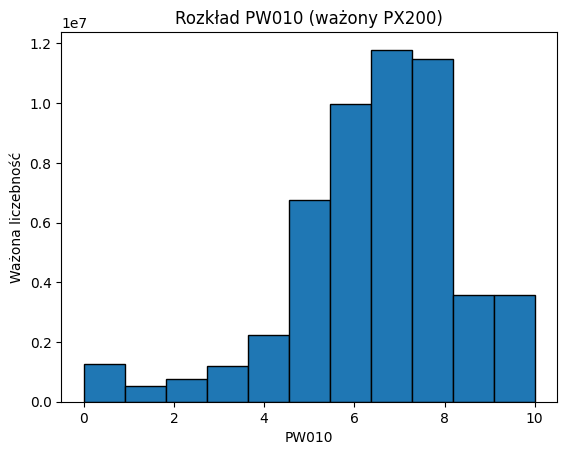

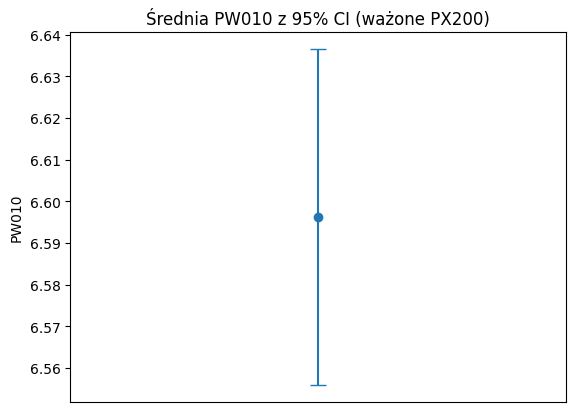

Średnia ważona: 6.59617785756452 CI: (np.float64(6.5558312720441405), np.float64(6.636524443084899))


C:\Users\User\AppData\Local\Temp\ipykernel_19492\1590645778.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(g) for g in d[WORK].cat.categories], showfliers=False)


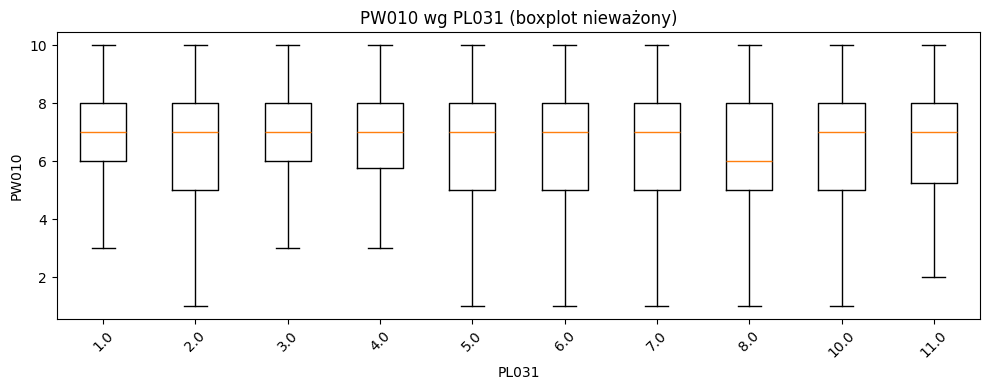

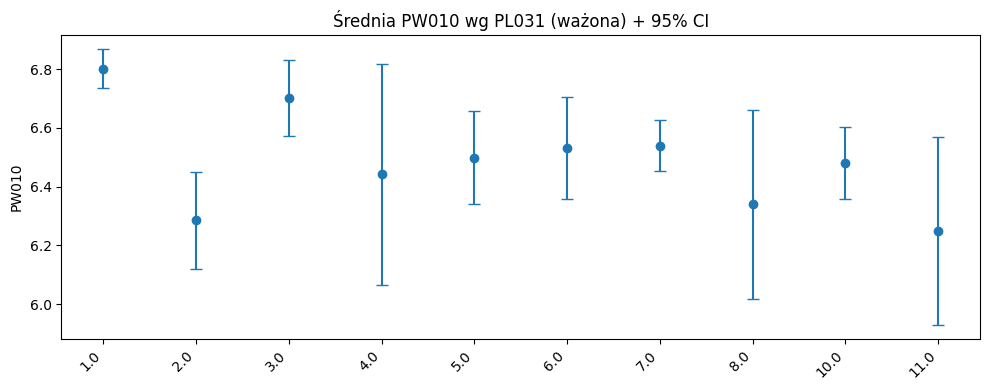


ANOVA (WLS) dla samego czynnika WORK:
                sum_sq       df         F        PR(>F)
C(PL031)  9.232825e+05      9.0  7.547545  4.101468e-11
Residual  2.221764e+08  16346.0       NaN           NaN

Kruskal-Wallis (bez wag) dla WORK:
KruskalResult(statistic=np.float64(114.15681664178537), pvalue=np.float64(2.0899801100343435e-20))


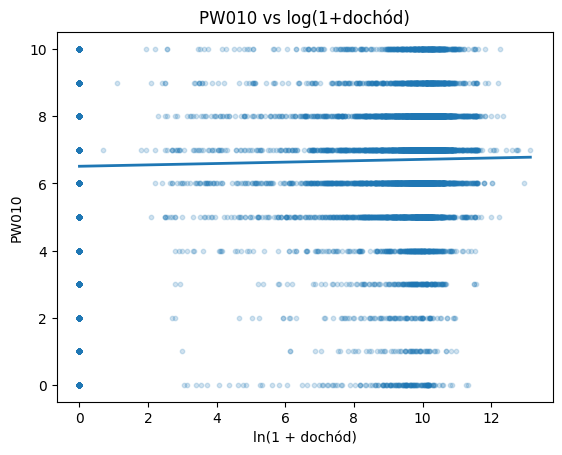


Regresja WLS: Y ~ ln_income
                            WLS Regression Results                            
Dep. Variable:                  PW010   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     25.01
Date:               pon., 12 sty 2026   Prob (F-statistic):           5.78e-07
Time:                        14:51:10   Log-Likelihood:                -37561.
No. Observations:               16477   AIC:                         7.513e+04
Df Residuals:                   16475   BIC:                         7.514e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5076  

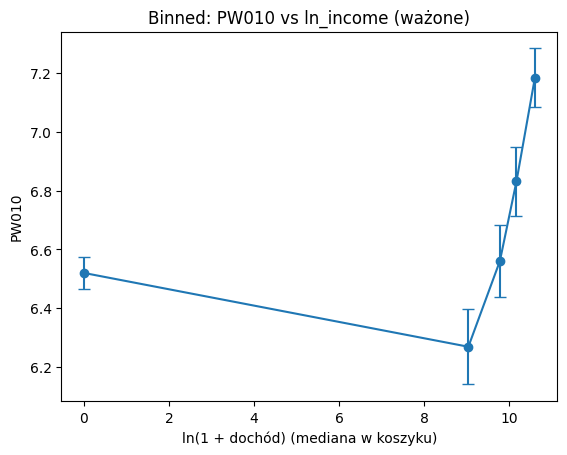

In [21]:
# wykresy i analizy

# 1) Wykres rozkładu dobrostanu: histogram (ważony)
# =========================
plt.figure()
plt.hist(d[Y], bins=11, weights=d[W], edgecolor="black")
plt.title(f"Rozkład {Y} (ważony {W})")
plt.xlabel(Y)
plt.ylabel("Ważona liczebność")
plt.show()

# =========================
# 2) Średnia dobrostanu + 95% CI (ważone)
# =========================
m, lo, hi = weighted_mean_ci(d[Y], d[W])
plt.figure()
plt.errorbar([0], [m], yerr=[[m-lo], [hi-m]], fmt="o", capsize=6)
plt.title(f"Średnia {Y} z 95% CI (ważone {W})")
plt.xticks([])
plt.ylabel(Y)
plt.show()

print("Średnia ważona:", m, "CI:", (lo, hi))

# =========================
# 3) Boxplot dobrostanu wg grup (np. status pracy) + (opcjonalnie) średnie ważone
#    (Boxplot jest nieważony; dokładny „survey-weighted boxplot” to osobny temat,
#     ale wizualnie to często wystarcza, a średnie ważone dają „prawdziwą” informację.)
# =========================
if WORK in d.columns:
    groups = [d.loc[d[WORK] == g, Y].dropna().values for g in d[WORK].cat.categories]
    plt.figure(figsize=(10, 4))
    plt.boxplot(groups, labels=[str(g) for g in d[WORK].cat.categories], showfliers=False)
    plt.title(f"{Y} wg {WORK} (boxplot nieważony)")
    plt.xlabel(WORK)
    plt.ylabel(Y)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # średnie ważone + CI na osobnym wykresie (patrz pkt 4)

# =========================
# 4) Średnia dobrostanu wg grup + 95% CI (ważone) + test różnic między grupami
# =========================
if WORK in d.columns:
    st = weighted_group_stats(d, WORK)
    plt.figure(figsize=(10, 4))
    x = np.arange(len(st))
    y = st["mean"].values
    yerr = np.vstack([y - st["ci_low"].values, st["ci_high"].values - y])
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, st["group"].astype(str), rotation=45, ha="right")
    plt.title(f"Średnia {Y} wg {WORK} (ważona) + 95% CI")
    plt.ylabel(Y)
    plt.tight_layout()
    plt.show()

    # TEST: "czy grupy różnią się po uwzględnieniu wag?" -> WLS + ANOVA
    m0 = smf.wls(f"{Y} ~ C({WORK})", data=d.dropna(subset=[WORK]), weights=d.dropna(subset=[WORK])[W]).fit(cov_type="HC3")
    print("\nANOVA (WLS) dla samego czynnika WORK:")
    print(anova_lm(m0, typ=2))

    # Alternatywa bez wag (gdy chcesz test nienormalny):
    samples = [d.loc[d[WORK] == g, Y].dropna().values for g in d[WORK].cat.categories]
    print("\nKruskal-Wallis (bez wag) dla WORK:")
    print(stats.kruskal(*samples))

# =========================
# 5) Scatter: dobrostan vs dochód (log) + linia trendu (WLS)
# =========================
if "ln_income" in d.columns and d["ln_income"].notna().sum() > 50:
    dd = d.dropna(subset=["ln_income"])
    plt.figure()
    plt.scatter(dd["ln_income"], dd[Y], s=10, alpha=0.2)
    plt.title(f"{Y} vs log(1+dochód)")

    # trend: WLS
    m_lin = smf.wls(f"{Y} ~ ln_income", data=dd, weights=dd[W]).fit(cov_type="HC3")
    xs = np.linspace(dd["ln_income"].min(), dd["ln_income"].max(), 100)
    ys = m_lin.params["Intercept"] + m_lin.params["ln_income"] * xs
    plt.plot(xs, ys, linewidth=2)

    plt.xlabel("ln(1 + dochód)")
    plt.ylabel(Y)
    plt.show()

    print("\nRegresja WLS: Y ~ ln_income")
    print(m_lin.summary())

# =========================
# 6) Binned scatter (średnie w koszykach) dla ciągłej zmiennej (np. dochód / bezpieczeństwo)
# =========================
def binned_weighted_means(df, xcol, ycol=Y, wcol=W, bins=10):
    dd = df.dropna(subset=[xcol, ycol, wcol]).copy()
    dd["bin"] = pd.qcut(dd[xcol], q=bins, duplicates="drop")
    out = []
    for b, sub in dd.groupby("bin", observed=True):
        m, lo, hi = weighted_mean_ci(sub[ycol], sub[wcol])
        x_mid = float(sub[xcol].median())
        out.append((x_mid, m, lo, hi))
    return pd.DataFrame(out, columns=["x_mid", "mean", "ci_low", "ci_high"]).sort_values("x_mid")

if "ln_income" in d.columns and d["ln_income"].notna().sum() > 50:
    b = binned_weighted_means(d, "ln_income", bins=10)
    plt.figure()
    plt.errorbar(b["x_mid"], b["mean"],
                 yerr=[b["mean"]-b["ci_low"], b["ci_high"]-b["mean"]],
                 fmt="o-", capsize=4)
    plt.title(f"Binned: {Y} vs ln_income (ważone)")
    plt.xlabel("ln(1 + dochód) (mediana w koszyku)")
    plt.ylabel(Y)
    plt.show()


MODEL WLS (pełny):
                            WLS Regression Results                            
Dep. Variable:                  PW010   R-squared:                       0.011
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.013
Date:               pon., 12 sty 2026   Prob (F-statistic):           1.03e-06
Time:                        15:26:57   Log-Likelihood:                -24253.
No. Observations:               10685   AIC:                         4.856e+04
Df Residuals:                   10660   BIC:                         4.874e+04
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           

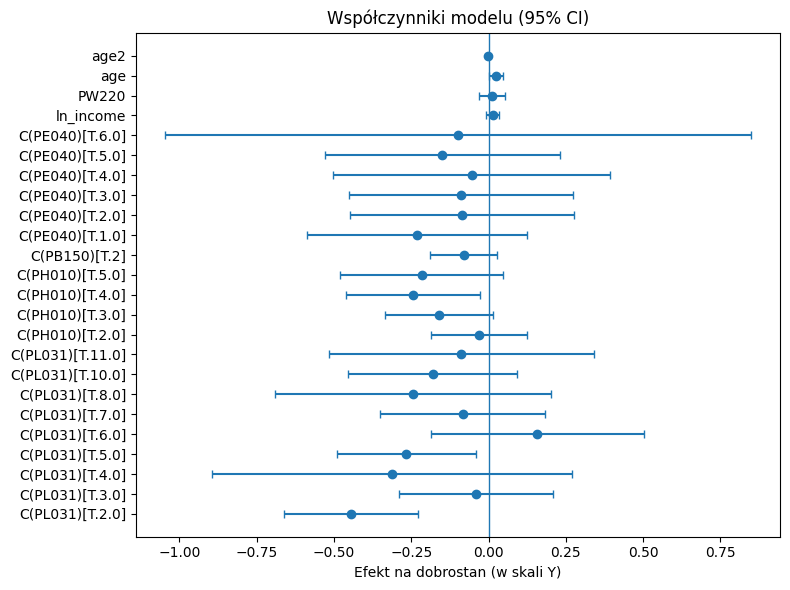

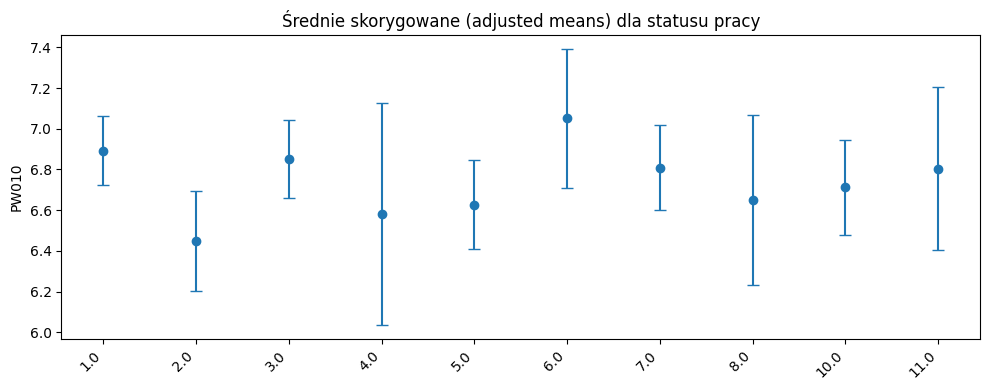


Model z interakcją HEALTH*age:
                    sum_sq       df         F    PR(>F)
C(PH010)      1.557520e+05      4.0  2.896495  0.020757
C(PB150)      2.953089e+04      1.0  2.196725  0.138334
C(PE040)      5.613974e+04      6.0  0.696015  0.652865
C(PL031)      3.266108e+05      9.0  2.699525  0.003886
age           6.248419e+04      1.0  4.648034  0.031111
C(PH010):age  6.498987e+04      4.0  1.208607  0.304781
ln_income     2.300160e+04      1.0  1.711029  0.190880
PW220         3.991852e+03      1.0  0.296943  0.585816
age2          4.862882e+04      1.0  3.617370  0.057206
Residual      1.432501e+08  10656.0       NaN       NaN


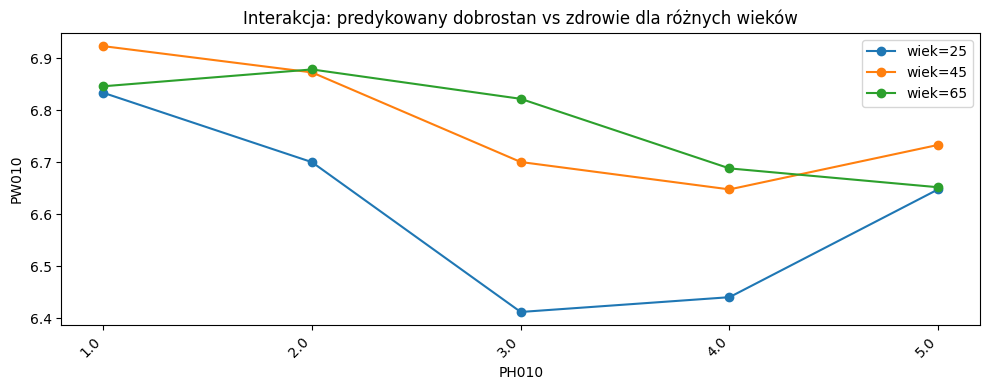

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# =========================
# 7) Model „co decyduje” + wykres współczynników (coefficient plot)
# =========================
# Model przykładowy (dopasuj pod swoje zmienne):
formula = f"{Y} ~ C({WORK}) + C({HEALTH}) + ln_income + {SEC} + age + age2 + C({SEX}) + C({EDU})"
# Uwaga: jeśli SEC ma dużo braków, model może się mocno zmniejszyć. Możesz go wywalić.
need = [WORK, HEALTH, SEX, EDU, SEC, "ln_income", "age", "age2"]
need = [c for c in need if c in d.columns]
dd = d.dropna(subset=need).copy()

m_full = smf.wls(formula, data=dd, weights=dd[W]).fit(cov_type="HC3")
print("\nMODEL WLS (pełny):")
print(m_full.summary())

# ANOVA Type II: które bloki są istotne „po kontroli”
print("\nANOVA Type II (pełny model):")
print(anova_lm(m_full, typ=2))

# Wykres współczynników (bez interceptu)
params = m_full.params.drop("Intercept", errors="ignore")
ci = m_full.conf_int().loc[params.index]
plt.figure(figsize=(8, max(4, 0.25 * len(params))))
ypos = np.arange(len(params))
plt.errorbar(params.values, ypos,
             xerr=[params.values - ci[0].values, ci[1].values - params.values],
             fmt="o", capsize=3)
plt.axvline(0, linewidth=1)
plt.yticks(ypos, params.index)
plt.title("Współczynniki modelu (95% CI)")
plt.xlabel("Efekt na dobrostan (w skali Y)")
plt.tight_layout()
plt.show()

# # =========================
# # 8) Adjusted means (średnie skorygowane) dla grup pracy (WORK)

    # 1) przygotuj jedną "bazową" obserwację (typowe wartości kowariat)
base = {
    "age": np.average(dd["age"], weights=dd[W]),
    "age2": np.average(dd["age"], weights=dd[W])**2,
    "ln_income": np.average(dd["ln_income"], weights=dd[W]),
    SEC: np.average(dd[SEC], weights=dd[W]),
    SEX: dd[SEX].mode().iloc[0],
    EDU: dd[EDU].mode().iloc[0],
    HEALTH: dd[HEALTH].mode().iloc[0],
}

# 2) zrób tabelę po grupach WORK
grid = pd.DataFrame({WORK: dd[WORK].cat.categories})
for k, v in base.items():
    if k in dd.columns:
        grid[k] = v

# 3) predykcje + CI
pred = m_full.get_prediction(grid).summary_frame()
out = grid[[WORK]].join(pred[["mean", "mean_ci_lower", "mean_ci_upper"]])

plt.figure(figsize=(10, 4))
x = np.arange(len(out))
y = out["mean"].values
yerr = np.vstack([y - out["mean_ci_lower"].values, out["mean_ci_upper"].values - y])
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.xticks(x, out[WORK].astype(str), rotation=45, ha="right")
plt.title("Średnie skorygowane (adjusted means) dla statusu pracy")
plt.ylabel(Y)
plt.tight_layout()
plt.show()


# =========================
# 9) Interakcja (moderacja): czy wpływ zdrowia zależy od wieku?
#    Model: Y ~ HEALTH + age + HEALTH:age + ...
# =========================
if HEALTH in dd.columns:
    formula_int = f"{Y} ~ C({HEALTH}) * age + ln_income + {SEC} + age2 + C({SEX}) + C({EDU}) + C({WORK})"
    m_int = smf.wls(formula_int, data=dd.dropna(subset=[HEALTH]), weights=dd.dropna(subset=[HEALTH])[W]).fit(cov_type="HC3")
    print("\nModel z interakcją HEALTH*age:")
    print(anova_lm(m_int, typ=2))  # zobacz czy interakcja istotna

    # Wykres predykcji dla kilku wieków (np. 25/45/65) w funkcji kategorii zdrowia
    ages = [25, 45, 65]
    base = {
        "ln_income": np.average(dd["ln_income"], weights=dd[W]),
        SEC: np.average(dd[SEC], weights=dd[W]) if SEC in dd.columns else 0.0,
        "age2": None,
        SEX: dd[SEX].mode().iloc[0],
        EDU: dd[EDU].mode().iloc[0],
        WORK: dd[WORK].mode().iloc[0],
    }

    health_cats = dd[HEALTH].cat.categories
    plt.figure(figsize=(10, 4))

    for a in ages:
        grid = pd.DataFrame({HEALTH: health_cats})
        grid["age"] = a
        grid["age2"] = a**2
        grid["ln_income"] = base["ln_income"]
        if SEC in dd.columns: grid[SEC] = base[SEC]
        grid[SEX] = base[SEX]
        grid[EDU] = base[EDU]
        grid[WORK] = base[WORK]

        pred = m_int.get_prediction(grid).summary_frame()
        plt.plot(np.arange(len(health_cats)), pred["mean"].values, marker="o", label=f"wiek={a}")

    plt.xticks(np.arange(len(health_cats)), [str(x) for x in health_cats], rotation=45, ha="right")
    plt.title("Interakcja: predykowany dobrostan vs zdrowie dla różnych wieków")
    plt.ylabel(Y)
    plt.xlabel(HEALTH)
    plt.legend()
    plt.tight_layout()
    plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_19492\1043632088.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Zero' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask_zero, "income_group"] = "Zero"
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


N po odfiltrowaniu braków: 15927
Kategorie zdrowia (PH010): [1.0, 2.0, 3.0, 4.0, 5.0]
Kategorie income_group: ['Low', 'Medium', 'High', 'Zero']

=== PODSUMOWANIE MODELU ===
                            WLS Regression Results                            
Dep. Variable:                  PW010   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     21.84
Date:               pon., 12 sty 2026   Prob (F-statistic):           2.07e-33
Time:                        15:52:00   Log-Likelihood:                -36212.
No. Observations:               15927   AIC:                         7.244e+04
Df Residuals:                   15918   BIC:                         7.251e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                coef 

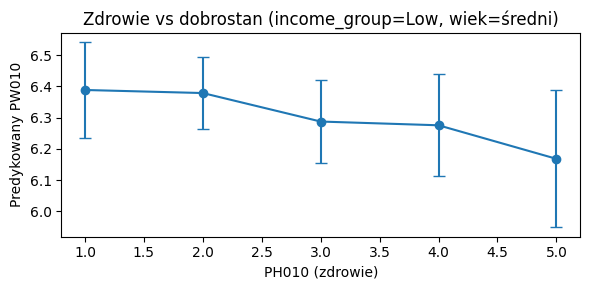

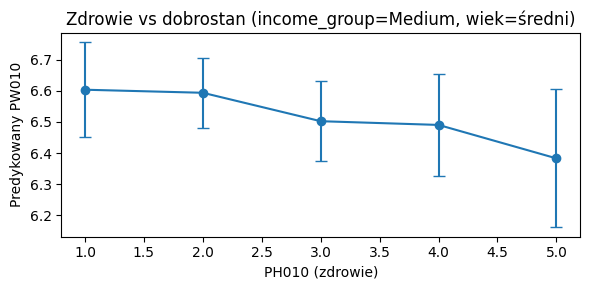

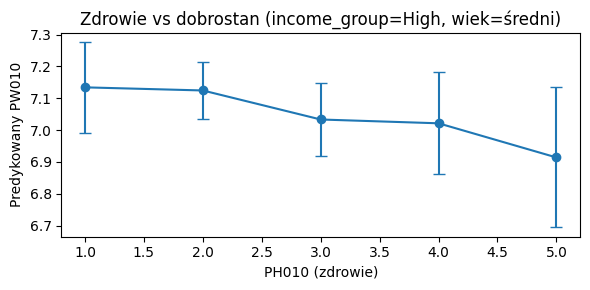

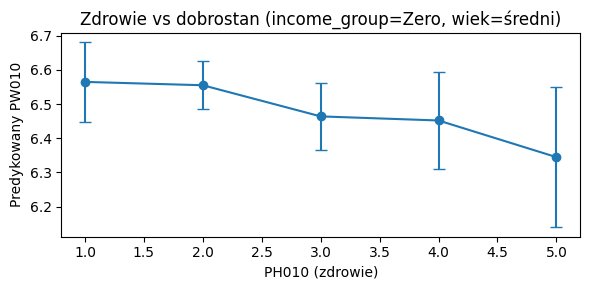

In [35]:
# ANCOVA dla EU-SILC (Włochy 2013)
# Cel: sprawdzić wpływ zdrowia (PH010) i dochodu (income) na dobrostan (PW010),
#      "wyrównując" (kontrolując) wiek (PX020).
#
# Model: PW010 ~ PH010 + income_group + age  (z wagami PX200)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ===== 1) Wczytanie danych =====
df = pd.read_csv("IT_2013p_EUSILC.csv")

Y = "PW010"       # dobrostan (0–10)
W = "PX200"       # wagi wellbeing
HEALTH = "PH010"  # stan zdrowia (1–5)
INCOME = "PY010G" # dochód (tu przykład)
AGE = "PX020"     # wiek

# ===== 2) Czyszczenie danych =====
def clean_silc(s):
    """NaN dla braków: ujemne kody oraz 99 (często 'don't know')."""
    s = pd.to_numeric(s, errors="coerce")
    s = s.where(s >= 0, np.nan)
    s = s.replace(99, np.nan)
    return s

for c in [Y, W, HEALTH, INCOME, AGE]:
    df[c] = clean_silc(df[c])

# zakresy sensowne (żeby nie wpuścić kodów spoza skali)
df[Y] = df[Y].where(df[Y].between(0, 10), np.nan)
df[HEALTH] = df[HEALTH].where(df[HEALTH].between(1, 5), np.nan)
df[AGE] = df[AGE].where(df[AGE].between(0, 80), np.nan)
df[W] = df[W].where(df[W] > 0, np.nan)

# ===== 3) Income jako czynnik (grupy) =====
# Robimy log(1+income), żeby zmniejszyć skośność, a potem tercyle dla dodatnich dochodów.
df["ln_income"] = np.log1p(df[INCOME])

df["income_group"] = np.nan
mask_zero = df["ln_income"].notna() & (df["ln_income"] == 0)
mask_pos  = df["ln_income"].notna() & (df["ln_income"] > 0)

df.loc[mask_zero, "income_group"] = "Zero"
df.loc[mask_pos,  "income_group"] = pd.qcut(df.loc[mask_pos, "ln_income"],
                                            q=3, labels=["Low", "Medium", "High"])

# ===== 4) Dane do modelu =====
d = df[[Y, W, HEALTH, AGE, "income_group"]].dropna().copy()
d[HEALTH] = d[HEALTH].astype("category")
d["income_group"] = d["income_group"].astype("category")

# ustaw kolejność grup, żeby "Low" było referencją (bazą)
order = [x for x in ["Low", "Medium", "High", "Zero"] if x in d["income_group"].cat.categories]
d["income_group"] = d["income_group"].cat.reorder_categories(order)

print("N po odfiltrowaniu braków:", len(d))
print("Kategorie zdrowia (PH010):", list(d[HEALTH].cat.categories))
print("Kategorie income_group:", list(d["income_group"].cat.categories))

# ===== 5) ANCOVA (ważona WLS + odporne błędy HC3) =====
# To jest dokładnie „wyrównujemy wiek” i patrzymy na zdrowie+dochód.
formula = f"{Y} ~ C({HEALTH}) + C(income_group) + {AGE}"
m = smf.wls(formula, data=d, weights=d[W]).fit(cov_type="HC3")

print("\n=== PODSUMOWANIE MODELU ===")
print(m.summary())

print("\n=== TESTY DLA CAŁYCH CZYNNIKÓW (Wald, robust) ===")
print(m.wald_test_terms().summary_frame())

# ===== 7) Wykres: skorygowane średnie (adjusted means) dla zdrowia =====
# Ustalamy: wiek = średni (ważony), income_group = 'Low' i porównujemy PH010.
ref_income = "Low" if "Low" in d["income_group"].cat.categories else d["income_group"].cat.categories[0]


for inc in d["income_group"].cat.categories:
    grid_h = pd.DataFrame({
        HEALTH: d[HEALTH].cat.categories,  # PH010 = 1..5
        "income_group": inc,               # tutaj zmieniamy grupę dochodu
        AGE: age_mean                      # stały wiek
    })

    pred = m.get_prediction(grid_h).summary_frame()

    y = pred["mean"].values
    yerr = np.vstack([y - pred["mean_ci_lower"].values,
                      pred["mean_ci_upper"].values - y])

    plt.figure(figsize=(6,3))
    plt.errorbar(grid_h[HEALTH].astype(float), y, yerr=yerr, fmt="o-", capsize=4)
    plt.xlabel("PH010 (zdrowie)")
    plt.ylabel("Predykowany PW010")
    plt.title(f"Zdrowie vs dobrostan (income_group={inc}, wiek=średni)")
    plt.tight_layout()
    plt.show()

